# Binary Cross Entropy and Mean Squared Loss Comparison: Part 2

We continue comparing and exploring differences between the functions for classification loss. In part one, 
we focused on one dataset example with 1000 cases and one feature. Where the search for the logistic regression parameters minimizing the classification loss was performed by gradient descent algorithm. 

The mean square error loss function has a global minimum, but has flat regions that can trap trajectory of gradient descent not allowing it to reach the global minimum. In general the gradient descent is slow with the mean squared error loss compared with the binary cross entropy loss. 

In part two, consider the mini-batch gradient descent. We experiment with various mini-batch sizes. For this purpose we plot the surface and contours for both loss functions using the mini-batch. 

mini-batch gradient descent we study the effect of:

1. mini-batch size.
2. learning rate
3. initial parameters. 

Later, we will consider different samples, where we change the degree of overlap of the classes,
having imbalanced classes. Imbalance is reflected in two ways:
1. number of cases per class
2. spread of cases per class, in the sense that one class may have a larger standard deviation, while the other have a smaller standard deviation.

In [4]:
import numpy as np
import pandas as pd
import time
from sklearn import datasets
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


import utils
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
import utils_mb 
from utils_mb import *

In [73]:
import importlib
importlib.reload(utils_mb)

<module 'utils_mb' from 'C:\\Users\\Hala\\Documents\\DeepLearning\\DLNHp\\ML_training_git\\CE_MSE_comparison\\utils_mb.py'>

### Create the dataset 

We create the dataset that we are working with using scikit-learn tool. 
For visualzation purposes we want only one feature. 

This is the same dataset we used in part one. 

In [3]:
X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=1,
                   random_state=0)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4, random_state = 1235)

(1000, 1)


Visualization of the dataset. 

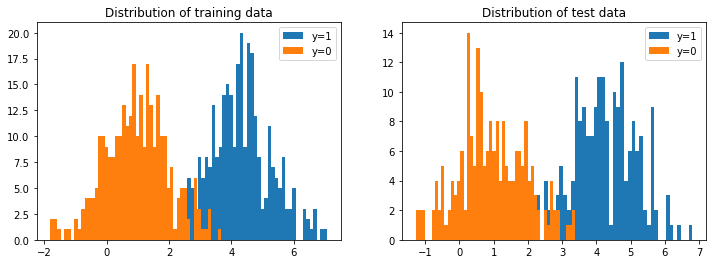

In [6]:
plt.subplots(1,2, figsize = (12,4))
plt.subplot(121)
plt.hist(X_train[y_train==1], bins = 50)
plt.hist(X_train[y_train==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of training data')

plt.subplot(122)
plt.hist(X_test[y_test==1], bins = 50)
plt.hist(X_test[y_test==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of test data')
plt.show()

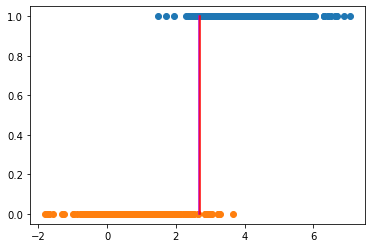

In [7]:
plt.scatter(X_train[y_train==1], y_train[y_train==1])
plt.scatter(X_train[y_train==0], y_train[y_train==0])
plt.plot([2.668, 2.668], [0, 1], 'm')
plt.plot([2.71, 2.71], [0,1], 'r')

The hypothesis function has the form:
$$ h_\theta(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x))}$$

to account for the intercept term in $\theta_0 + \theta_1 x$ we add a column of ones to the data matrix X

In [10]:
X_train_o = np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_test_o = np.hstack((np.ones((X_test.shape[0],1)),X_test))

We define below the cross entropy cost function and mean square error cost function. 

For visualization of the cross entropy I needed to modify the sigmoid function. The logarithm of sigmoid when its value is 0.0 or the logarithm of 1-sigmoid when the sigmoid value is 1.0, becomes `-inf`. To avoid these cases. I modify the sigmoid function as in part one.

In [6]:
def costFunction(theta, X, y):
    '''
    We define here the cross entropy loss function
    takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(X)  
    
    #initialize loss J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    z = np.dot(theta,X.T)
    pred = sigmoid(z)
    
    # for visualization purposes we do not want the pred
    # to take 1 or 0 values so that the log(pre) and 
    # log(1-pred) do not taake -inf values. 
    pred[pred > 0.999] = pred[pred>0.999] - 1e-10
    pred[pred < 0.001] = pred[pred<0.001] + 1e-10
    
    # cross entropy loss
    J = (-1/m)*((np.dot(y,np.log(pred)))+ np.dot(1-y,np.log(1-pred))) 
    
    # the gradient of the J with respect to theta
    grad = (1/m) * np.dot((pred-y).T,X)
    
    
    return J, grad


def costFunction_MSE(theta, X,y):
    '''
    We define here the mean squared error loss function.
    it takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(X)
    
    #initialize J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    
    z = np.dot(theta,X.T)
    pred = sigmoid(z)
    
    J = (1/(2*m))* np.dot(y-pred, y-pred)
    
    # gradient of J with respect to theta has extra
    # step of computing h'
    hp = sigmoid_grad(z)
    grad = (-1/m) * np.dot((hp*(y-pred)).T,X)
    
    return J, grad


Below we define the function to make the mini-batches and the gradient descent alogrithm that updates the parameters using the gradinet of the loss function per minibatch (rather than the gradient loss using the whole data set at once). This process repeats and iterates over the minibatches for the assigned number of epochs (iterations).  

The generated dataset is shuffled, therefore we do not shuffle again. 

In [7]:
def make_mini_batches(X,y,batch_size):
    m = len(X)
    num_batches = m // batch_size
    mini_batches = []
    for k in range(num_batches):
        X_mini_batch = X[k*batch_size:(k+1)*batch_size,:]
        y_mini_batch = y[k*batch_size:(k+1)*batch_size]
        mini_batches.append((X_mini_batch,y_mini_batch))
    if m % batch_size != 0:
        X_mini_batch = X[num_batches * batch_size:,]
        y_mini_batch = y[num_batches * batch_size:]
        mini_batches.append((X_mini_batch, y_mini_batch))
    return mini_batches

def mini_bGD(costFunc, X, y, theta, batch_size, alpha, epochs):
    J_hist = []
    theta_hist = []
    #works faster when included inside the loop
    mini_batches = make_mini_batches(X,y, batch_size)
            
    for epoch in range(epochs):
        for mini_b in mini_batches:
            X,y = mini_b
            J, grad = costFunc(theta, X, y)
            theta = theta - alpha * grad
        #save results per epoch
        J_hist.append(J)
        theta_hist.append(theta)
        # check theta is improving
        if epoch > 100:
            theta_step = theta_hist[-2] - theta_hist[-1]
        
            # stop if improvement in theta is at machine epsilon scale
            if (abs(theta_step[0]) < 1/(2**50)) & (abs(theta_step[1]) < 1/(2**50)):
                print('early stop due to theta_step close to machine epsilon :', theta_step) 
                return theta, J_hist, theta_hist
        
        
        if epoch % 10000 == 0:
            print('epoch : {},  theta : {},  loss : {:0.8f} '.format(epoch, theta, J))
    return theta, J_hist, theta_hist        

In [8]:
model_hist_bce = {}
model_hist_mse = {}

In [11]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 0.1
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', np.mean(J_hist[-1:]))


epoch : 0,  theta : [-0.57853902  0.52095332],  loss : 0.41916764 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 0.9491 minutes
theta converged to:  [-9.54548924  3.56270274]
desicion boundary : x >=  2.6792830960017677
loss at convergence :  0.05575732292292647


In [12]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 1.0
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-3.28467831  1.39059512],  loss : 0.19278128 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.1029 minutes
theta converged to:  [-9.77045951  3.59318781]
desicion boundary : x >=  2.7191619359378767
loss at convergence :  0.0555013476434674


In [13]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 0.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-2.16555207  1.05037191],  loss : 0.25575319 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.2235 minutes
theta converged to:  [-9.60619144  3.53426423]
desicion boundary : x >=  2.7180173327515598
loss at convergence :  0.053901363795676865


In [14]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 1.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-4.16116722  1.63560396],  loss : 0.16614035 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.0756 minutes
theta converged to:  [-10.03696956   3.70507536]
desicion boundary : x >=  2.7089785212297843
loss at convergence :  0.060971241579573364


In [15]:
for key in model_hist_bce:
    model_hist_bce[key]['actual_epochs'] = len(model_hist_bce[key]['loss'])
    print(key+'. Actual number of epochs :',len(model_hist_bce[key]['loss']))

epochs 100000 lr 0.1 batch_size 16. Actual number of epochs : 6141
epochs 100000 lr 1.0 batch_size 16. Actual number of epochs : 688
epochs 100000 lr 0.5 batch_size 16. Actual number of epochs : 1344
epochs 100000 lr 1.5 batch_size 16. Actual number of epochs : 485


In [16]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 0.1
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-0.10697992  0.28899792],  loss : 0.08253364 
epoch : 10000,  theta : [-8.76198981  3.2804894 ],  loss : 0.00684494 
epoch : 20000,  theta : [-8.80659858  3.29676465],  loss : 0.00679444 
epoch : 30000,  theta : [-8.8077376   3.29718029],  loss : 0.00679316 
epoch : 40000,  theta : [-8.80776704  3.29719103],  loss : 0.00679312 
epoch : 50000,  theta : [-8.8077678   3.29719131],  loss : 0.00679312 
epoch : 60000,  theta : [-8.80776782  3.29719131],  loss : 0.00679312 
epoch : 70000,  theta : [-8.80776782  3.29719131],  loss : 0.00679312 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 9.6142 minutes
theta converged to:  [-8.80776782  3.29719131]
desicion boundary : x >=  2.6712941339159353
loss at convergence :  0.0067931210722768495


In [17]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 1.0
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-1.22018554  0.64571945],  loss : 0.04960094 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 0.9257 minutes
theta converged to:  [-8.81172174  3.26069915]
desicion boundary : x >=  2.702402567040065
loss at convergence :  0.006434904284165078


In [18]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 0.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-0.69269124  0.47623427],  loss : 0.06342632 
epoch : 10000,  theta : [-8.79924452  3.27729291],  loss : 0.00665039 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 1.8904 minutes
theta converged to:  [-8.79924454  3.27729291]
desicion boundary : x >=  2.684912448072445
loss at convergence :  0.0066503877820899985


In [19]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 16
lr = 1.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-1.61012062  0.76971826],  loss : 0.04168138 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.6742 minutes
theta converged to:  [-8.85187974  3.25624611]
desicion boundary : x >=  2.7184308052913226
loss at convergence :  0.006219320370828132


In [20]:
#MSE actual epochs: 
for key in model_hist_mse:
    model_hist_mse[key]['actual_epochs'] = len(model_hist_mse[key]['loss'])
    print(key+'. Actual number of epochs :',len(model_hist_mse[key]['loss']))

epochs 100000 lr 0.1 batch_size 16. Actual number of epochs : 71748
epochs 100000 lr 1.0 batch_size 16. Actual number of epochs : 7419
epochs 100000 lr 0.5 batch_size 16. Actual number of epochs : 15044
epochs 100000 lr 1.5 batch_size 16. Actual number of epochs : 5089


In [21]:
iterations_info = pd.DataFrame(columns = ['model','LR','num_iter'])
i = 0
for key in model_hist_bce:
    iterations_info.loc[i,'model'] = 'Cross Entropy'
    iterations_info.loc[i,'LR'] = model_hist_bce[key]['LR']
    iterations_info.loc[i,'num_iter'] = model_hist_bce[key]['actual_epochs']
    i += 1

for key in model_hist_mse:
    iterations_info.loc[i,'model'] = 'Mean Squared Error'
    iterations_info.loc[i,'LR'] = model_hist_mse[key]['LR']
    iterations_info.loc[i,'num_iter'] = model_hist_mse[key]['actual_epochs']
    i += 1

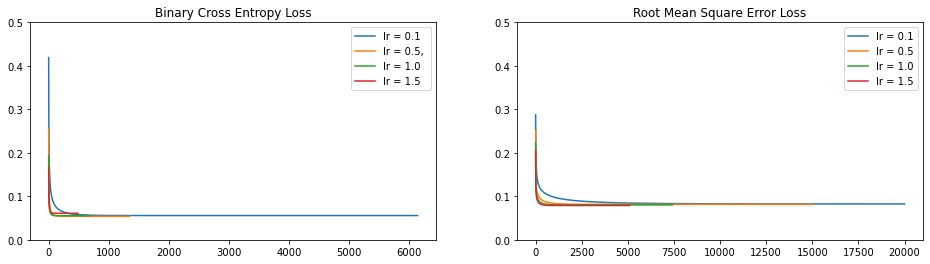

In [23]:
plt.subplots(1,2,figsize=(16,4))
plt.subplot(1,2,1)
key_name = 'epochs 100000 lr 0.1 batch_size 16'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
key_name = 'epochs 100000 lr 0.5 batch_size 16'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
key_name = 'epochs 100000 lr 1.0 batch_size 16'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
key_name = 'epochs 100000 lr 1.5 batch_size 16'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
plt.ylim((0,.5))
plt.legend(['lr = 0.1', 'lr = 0.5, ','lr = 1.0', 'lr = 1.5'])
plt.title('Binary Cross Entropy Loss')

plt.subplot(1,2,2)
key_name = 'epochs 100000 lr 0.1 batch_size 16'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
key_name = 'epochs 100000 lr 0.5 batch_size 16'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
key_name = 'epochs 100000 lr 1.0 batch_size 16'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
key_name = 'epochs 100000 lr 1.5 batch_size 16'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
plt.ylim((0,.5))
plt.legend(['lr = 0.1', 'lr = 0.5', 'lr = 1.0', 'lr = 1.5'])
plt.title('Root Mean Square Error Loss')

plt.show()

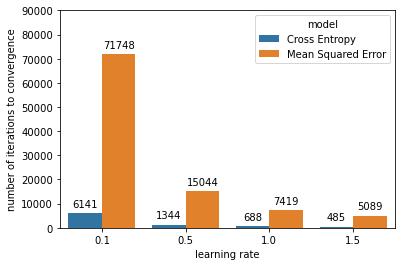

In [37]:
# code to annotate barplot sourse
#https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/

splot = sns.barplot(x='LR',y='num_iter', hue = 'model',data = iterations_info)
for p in splot.patches:
    splot.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel('learning rate')
plt.ylabel('number of iterations to convergence')
plt.ylim((0,90000))
plt.show()

The experiments above show that minibatch GD with batch size of 32 converge to the same respecive values using GD. The MSE loss function converge significantly slower than the binary cross enropy loss function. 

Moreover, the larger the learning rate the faster the DG converges.

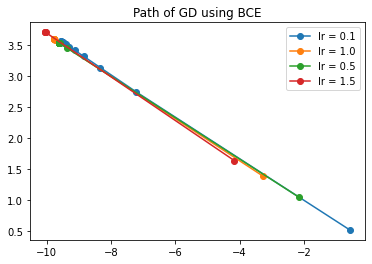

In [38]:
for key in model_hist_bce:
    theta_hist = model_hist_bce[key]['theta_hist']
    L = len(theta_hist)
    M = min(L, 1000)
    
    th_short_list = [theta_hist[i] for i in range(0,M,100)]
    [th_short_list.append(theta_hist[i]) for i in range(M,L,2000)]

    ths11 = []
    ths22 = []

    for i in range(len(th_short_list)):
        ths11.append(th_short_list[i][0])
        ths22.append(th_short_list[i][1])
    plt.plot(ths11,ths22,'o-')
    #plt.ylim((3,4))
    #plt.xlim((-10,-8))
    
plt.legend(['lr = 0.1', 'lr = 1.0', 'lr = 0.5', 'lr = 1.5'])
plt.title ('Path of GD using BCE')
plt.show()

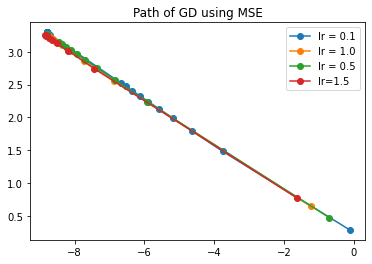

In [39]:
for key in model_hist_mse:
    theta_hist = model_hist_mse[key]['theta_hist']
    L = len(theta_hist)
    th_mse_short_list = [theta_hist[i] for i in range(0,1000,100)]
    [th_mse_short_list.append(theta_hist[i]) for i in range(8000,L,2000)]

    ths11 = []
    ths22 = []

    for i in range(len(th_mse_short_list)):
        ths11.append(th_mse_short_list[i][0])
        ths22.append(th_mse_short_list[i][1])
    plt.plot(ths11,ths22,'o-')
    #plt.ylim((3,4))
    #plt.xlim((-9,-8))
    
plt.legend(['lr = 0.1', 'lr = 1.0', 'lr = 0.5', 'lr=1.5'])
plt.title('Path of GD using MSE')
plt.show()

In [42]:
key = 'epochs 100000 lr 1.0 batch_size 16'
theta_hist = model_hist_bce[key]['theta_hist']
L = len(theta_hist)
M = min(800,L)
th_short_list = [theta_hist[i] for i in range(0,M,100)]
[th_short_list.append(theta_hist[i]) for i in range(M,L,2000)]

#optimal value
theta_ce2 = theta_hist[-1]

ths1 = []
ths2 = []

for i in range(len(th_short_list)):
    ths1.append(th_short_list[i][0])
    ths2.append(th_short_list[i][1])

In [43]:
key = 'epochs 100000 lr 1.0 batch_size 16'
theta_hist = model_hist_mse[key]['theta_hist']
L = len(theta_hist)
M = min(0,800)
th_mse_short_list = [theta_hist[i] for i in range(0,M,100)]
[th_mse_short_list.append(theta_hist[i]) for i in range(M,L,2000)]

theta_mse2 = theta_hist[-1]
ths11 = []
ths22 = []

for i in range(len(th_mse_short_list)):
    ths11.append(th_mse_short_list[i][0])
    ths22.append(th_mse_short_list[i][1])

In [44]:
mini_batches = make_mini_batches(X_train_o,y_train, batch_size)


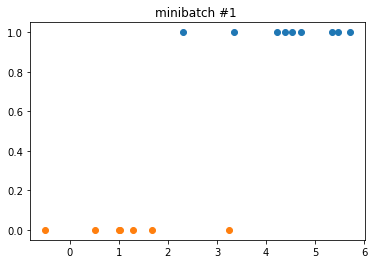

In [45]:
xx, yy = mini_batches[1]
plt.scatter(xx[yy==1,1], yy[yy==1])
plt.scatter(xx[yy==0,1], yy[yy==0])
plt.title('minibatch #1 ')
plt.show()

In [46]:
# good view using x1: [-12,6], x2: [-6, 12]
x1 = np.sort(np.concatenate((np.linspace(-80,80,401),np.array(ths1))))
x2 = np.sort(np.concatenate((np.linspace(-80,80,401),np.array(ths2))))
x12, x21 = np.meshgrid(x1, x2)


J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, xx, yy)

In [47]:
Js12 = np.zeros(len(ths1))
for i in range(len(ths1)):
    theta = np.array([ths1[i], ths2[i]])
    Js12[i], _ = costFunction(theta, xx, yy)

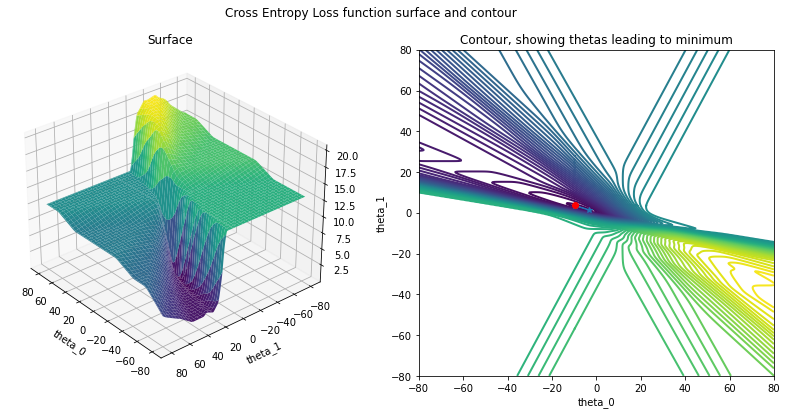

In [48]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [49]:
K12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, xx, yy)

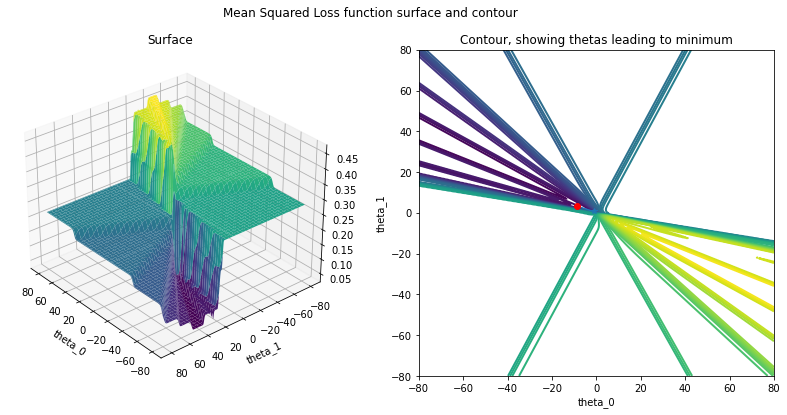

In [50]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, K12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Mean Squared Loss function surface and contour')
plt.show()

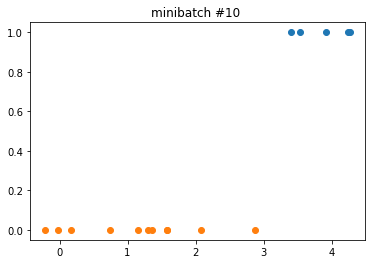

38

In [58]:
xx2, yy2 = mini_batches[10]
plt.scatter(xx2[yy2==1,1], yy2[yy2==1])
plt.scatter(xx2[yy2==0,1], yy2[yy2==0])
plt.title('minibatch #10 ')
plt.show()
len(mini_batches)

In [59]:
J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, xx2, yy2)

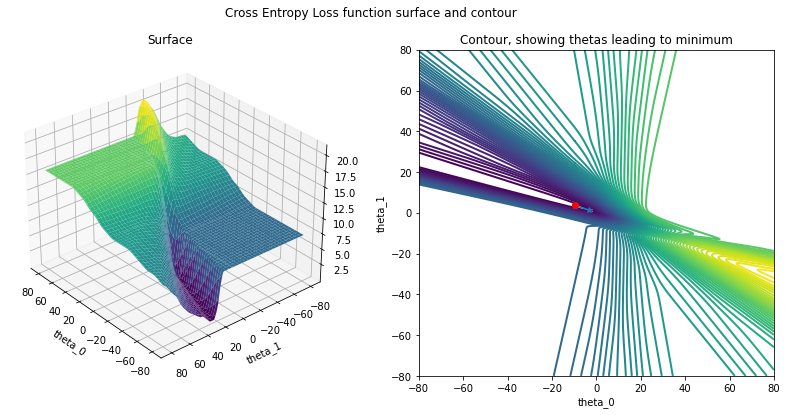

In [60]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [61]:
K12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, xx2, yy2)

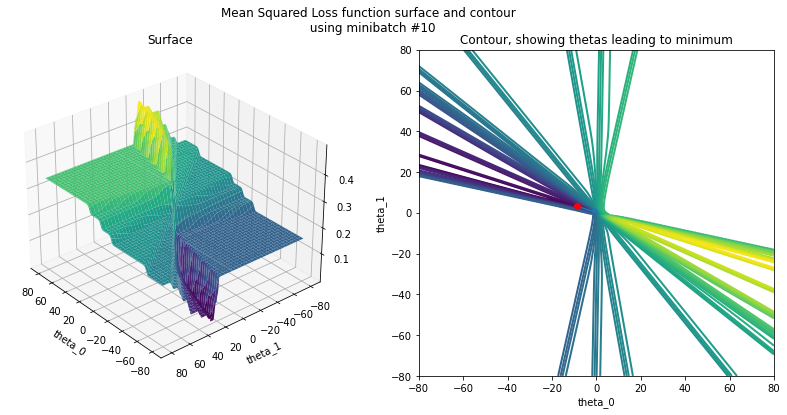

In [62]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, K12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Mean Squared Loss function surface and contour \n using minibatch #10')
plt.show()

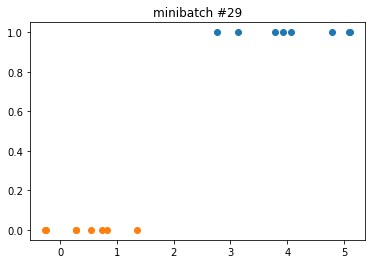

In [75]:
batch_num=29
xx3, yy3 = mini_batches[batch_num]
plt.scatter(xx3[yy3==1,1], yy3[yy3==1])
plt.scatter(xx3[yy3==0,1], yy3[yy3==0])
plt.title('minibatch #'+str(batch_num))
plt.show()

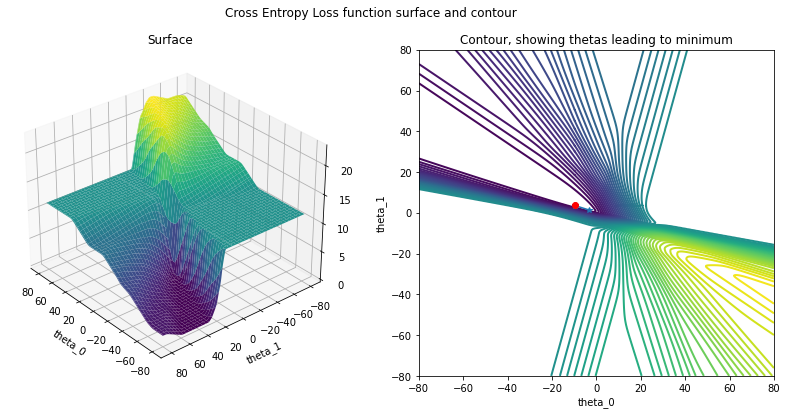

In [66]:


J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, xx3, yy3)

#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [67]:
K12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, xx3, yy3)

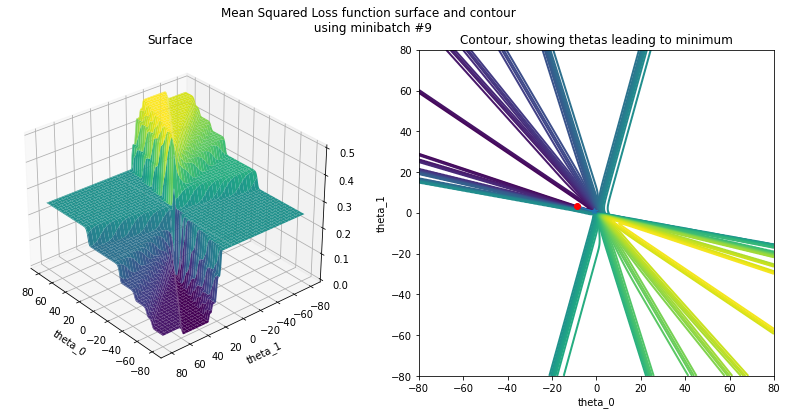

In [68]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, K12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Mean Squared Loss function surface and contour \n using minibatch #9')
plt.show()

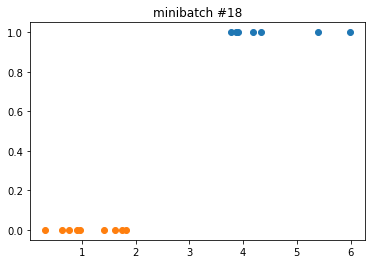

In [70]:
batch_number = 18
xx4, yy4 = mini_batches[batch_number]
plt.scatter(xx4[yy4==1,1], yy4[yy4==1])
plt.scatter(xx4[yy4==0,1], yy4[yy4==0])
plt.title('minibatch #'+str(batch_number))
plt.show()

# Testing with challenging initial parameter values

We start with testing some values that we checked in part 1 where we used the whole batch. Here we select with few test case.

In [71]:
theta_mse2

array([-8.81172174,  3.26069915])

theta_0_lcm  [10.5 -5.5]
epoch : 0,  theta : [ 9.97391025 -6.28950112],  loss : 0.42883734 
epoch : 10000,  theta : [-10.32964872  -3.07708923],  loss : 0.31250000 
epoch : 20000,  theta : [-10.41932281  -2.9214953 ],  loss : 0.31250000 
epoch : 30000,  theta : [-10.47097659  -2.83059615],  loss : 0.31250000 
epoch : 40000,  theta : [-10.50715422  -2.76578565],  loss : 0.31250000 
epoch : 50000,  theta : [-10.534846    -2.71513433],  loss : 0.31250000 
epoch : 60000,  theta : [-10.55715282  -2.67336612],  loss : 0.31250000 
epoch : 70000,  theta : [-10.57572563  -2.63767954],  loss : 0.31250000 
epoch : 80000,  theta : [-10.59154901  -2.60640784],  loss : 0.31250000 
epoch : 90000,  theta : [-10.60525778  -2.57847853],  loss : 0.31250000 
mini batch GD took 16.042 minutes
Minimizing theta (lr = 1.0)  [-10.61728419  -2.553163  ]
Loss value (lr = 1.0)  0.31249999933042877
Computations for surface plots time 1.126 minutes


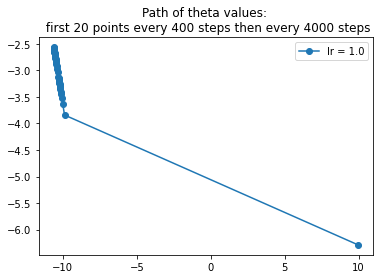

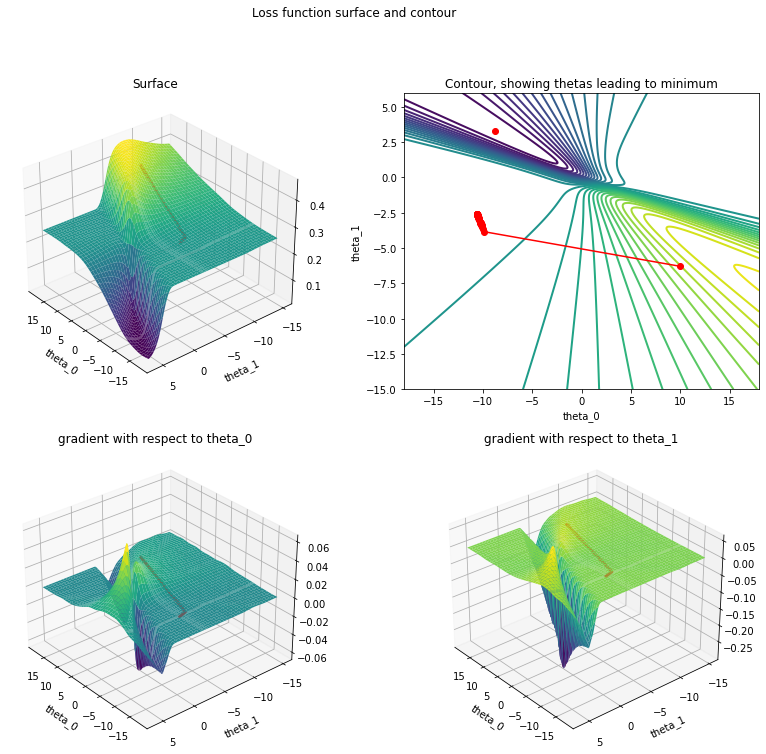

In [74]:
theta_0_lcm = np.array([10.5, -5.5])
iterations = 100000
batch_size = 16
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils_mb.local_min_plots(costFunction_MSE, X_train_o, y_train, theta_0_lcm, batch_size, \
                         iterations, xmin, xmax, ymin, ymax, theta_mse2)

theta_0_lcm  [13.5 -5. ]
epoch : 0,  theta : [13.81199765 -3.82890696],  loss : 0.42547574 
epoch : 10000,  theta : [13.1021702  -1.28729019],  loss : 0.18749234 
epoch : 20000,  theta : [-8.81171933  3.26069827],  loss : 0.00643491 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mini batch GD took 3.464 minutes
Minimizing theta (lr = 1.0)  [-8.81172174  3.26069915]
Loss value (lr = 1.0)  0.006434904284165078
Computations for surface plots time 1.577 minutes


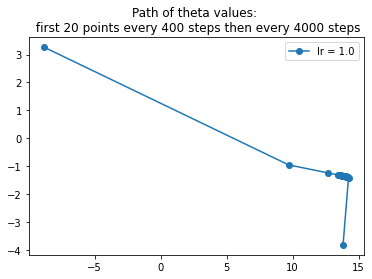

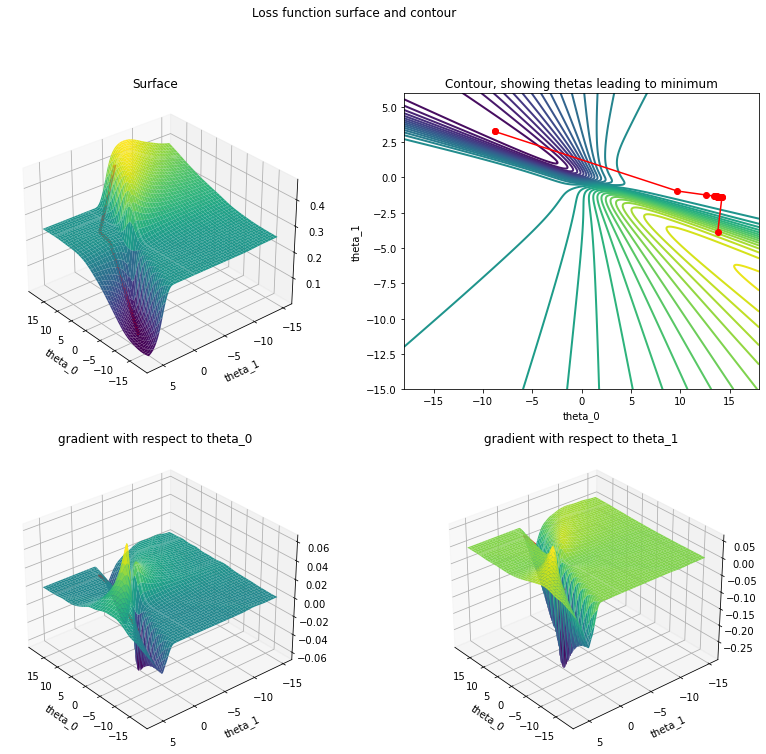

In [76]:
theta_0_lcm = np.array([13.5, -5.0])
iterations = 100000
batch_size = 16
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils_mb.local_min_plots(costFunction_MSE, X_train_o, y_train, theta_0_lcm, batch_size, \
                         iterations, xmin, xmax, ymin, ymax, theta_mse2)